# 🎯 Model Evaluation - Final Performance Analysis

Ce notebook évalue le meilleur modèle entraîné :
1. Charger le modèle en production
2. Évaluer sur le test set
3. Visualiser les prédictions
4. Analyser les erreurs
5. Feature importance

Cellule 2 : "Imports"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Ajouter src au path
sys.path.append('..')

from src.models.utils import ModelLoader, ModelPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Imports successful")

✅ Imports successful


Cellule 3 : "1️⃣ Charger le Modèle en Production"


In [2]:
# Lister tous les modèles disponibles
loader = ModelLoader()
models_df = loader.compare_models()

print("\n" + "="*70)
print("MODELS AVAILABLE")
print("="*70)

✅ Models directory found: C:\Users\akram\OneDrive\Bureau\premier_league_mlops\models\production

📊 Available Models (4):

      timestamp              name  val_mae  test_mae  test_r2                                                                                                    file
20251212_215937 ensemble_stacking 4.576537  5.185233 0.853422 C:\Users\akram\OneDrive\Bureau\premier_league_mlops\models\production\best_model_20251212_215937.joblib
20251212_215739 ensemble_stacking 4.576537  5.185233 0.853422                                                                       best_model_20251212_215739.joblib
20251212_214910 ensemble_stacking 4.576537  5.185233 0.853422                                                                       best_model_20251212_214910.joblib
20251211_212435 ensemble_stacking 4.576537  5.185233 0.853422                                                                       best_model_20251211_212435.joblib

MODELS AVAILABLE


Cellule 4 : "Charger le dernier modèle"

In [3]:
# Charger le dernier modèle (le meilleur)
predictor = ModelPredictor()

print("\n📋 Model Information:")
print(f"   Model Name: {predictor.metadata['model_name']}")
print(f"   Timestamp: {predictor.metadata['timestamp']}")
print(f"   Number of Features: {predictor.metadata['n_features']}")

print("\n📊 Validation Metrics:")
print(f"   Val MAE:  {predictor.metadata['metrics']['val_mae']:.2f} points")
print(f"   Val RMSE: {predictor.metadata['metrics']['val_rmse']:.2f} points")
print(f"   Val R²:   {predictor.metadata['metrics']['val_r2']:.4f}")

print("\n📊 Test Metrics:")
print(f"   Test MAE:  {predictor.metadata['metrics']['test_mae']:.2f} points")
print(f"   Test RMSE: {predictor.metadata['metrics']['test_rmse']:.2f} points")
print(f"   Test R²:   {predictor.metadata['metrics']['test_r2']:.4f}")

✅ Models directory found: C:\Users\akram\OneDrive\Bureau\premier_league_mlops\models\production
🔍 Looking for model at: C:\Users\akram\OneDrive\Bureau\premier_league_mlops\models\production\latest_model.joblib
🔍 Looking for metadata at: C:\Users\akram\OneDrive\Bureau\premier_league_mlops\models\production\latest_metadata.json
✅ Loaded model: ensemble_stacking
   Timestamp: 20251212_215937
   Val MAE: 4.58
   Test MAE: 5.19

📋 Model Information:
   Model Name: ensemble_stacking
   Timestamp: 20251212_215937
   Number of Features: 38

📊 Validation Metrics:
   Val MAE:  4.58 points
   Val RMSE: 6.45 points
   Val R²:   0.8830

📊 Test Metrics:
   Test MAE:  5.19 points
   Test RMSE: 6.79 points
   Test R²:   0.8534


Cellule 5 : "2️⃣ Charger les Données de Test"

In [4]:
# Charger le test set
test_df = pd.read_parquet('../data/processed/v1/test.parquet')

print(f"📊 Test Set Information:")
print(f"   Total records: {len(test_df):,}")
print(f"   Season: {test_df['season'].unique()}")
print(f"   Teams: {test_df['team'].nunique()}")
print(f"   Gameweeks: {test_df['gameweek'].min()} to {test_df['gameweek'].max()}")

# Séparer features et target
metadata_cols = ['season', 'team', 'gameweek']
target_col = 'target_final_points'
feature_cols = [col for col in test_df.columns if col not in metadata_cols + [target_col]]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"\n   Features: {len(feature_cols)}")
print(f"   Samples: {len(X_test):,}")

📊 Test Set Information:
   Total records: 580
   Season: ['2022-2023']
   Teams: 20
   Gameweeks: 10 to 38

   Features: 38
   Samples: 580


Cellule 6 : "3️⃣ Faire les Prédictions"

In [5]:
# Prédictions
y_pred = predictor.predict(X_test)

# Calculer les métriques
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n" + "="*70)
print("TEST SET PERFORMANCE")
print("="*70)
print(f"\nMAE (Mean Absolute Error):  {mae:.2f} points")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} points")
print(f"R² Score: {r2:.4f}")
print(f"\n💡 Interpretation:")
print(f"   The model predicts final points with an average error of {mae:.2f} points")
print(f"   The model explains {r2*100:.2f}% of the variance in final points")


TEST SET PERFORMANCE

MAE (Mean Absolute Error):  5.19 points
RMSE (Root Mean Squared Error): 6.79 points
R² Score: 0.8534

💡 Interpretation:
   The model predicts final points with an average error of 5.19 points
   The model explains 85.34% of the variance in final points


Cellule 7 : "4️⃣ Visualiser les Prédictions vs Réalité"

In [6]:
# Créer un DataFrame avec prédictions et réalité
results_df = test_df[['team', 'gameweek']].copy()
results_df['actual'] = y_test.values
results_df['predicted'] = y_pred
results_df['error'] = results_df['actual'] - results_df['predicted']
results_df['abs_error'] = np.abs(results_df['error'])

print("📊 Sample Predictions:")
print(results_df.head(10))

📊 Sample Predictions:
                team  gameweek  actual  predicted      error  abs_error
0  Tottenham Hotspur        10      60  76.002242 -16.002242  16.002242
1  Tottenham Hotspur        11      60  77.485556 -17.485556  17.485556
2  Tottenham Hotspur        12      60  73.530287 -13.530287  13.530287
3  Tottenham Hotspur        13      60  68.896318  -8.896318   8.896318
4  Tottenham Hotspur        14      60  70.243255 -10.243255  10.243255
5  Tottenham Hotspur        15      60  67.945497  -7.945497   7.945497
6  Tottenham Hotspur        16      60  69.003666  -9.003666   9.003666
7  Tottenham Hotspur        17      60  67.853187  -7.853187   7.853187
8  Tottenham Hotspur        18      60  65.439374  -5.439374   5.439374
9  Tottenham Hotspur        19      60  66.772253  -6.772253   6.772253


Cellule 8 : "Scatter plot: Prédictions vs Réalité"

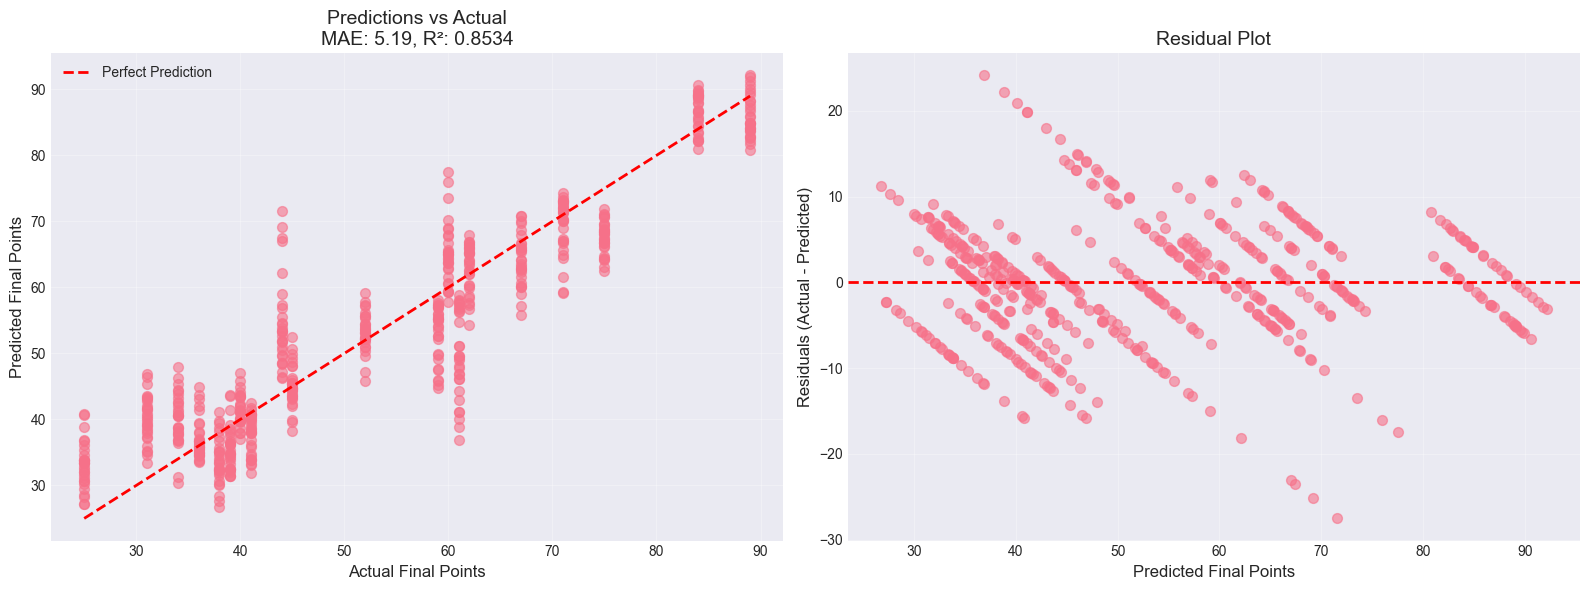

In [7]:
# Scatter plot: Prédictions vs Réalité
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter plot
axes[0].scatter(y_test, y_pred, alpha=0.6, s=50)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Final Points', fontsize=12)
axes[0].set_ylabel('Predicted Final Points', fontsize=12)
axes[0].set_title(f'Predictions vs Actual\nMAE: {mae:.2f}, R²: {r2:.4f}', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.6, s=50)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Final Points', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Cellule 9 : "Distribution des erreurs"

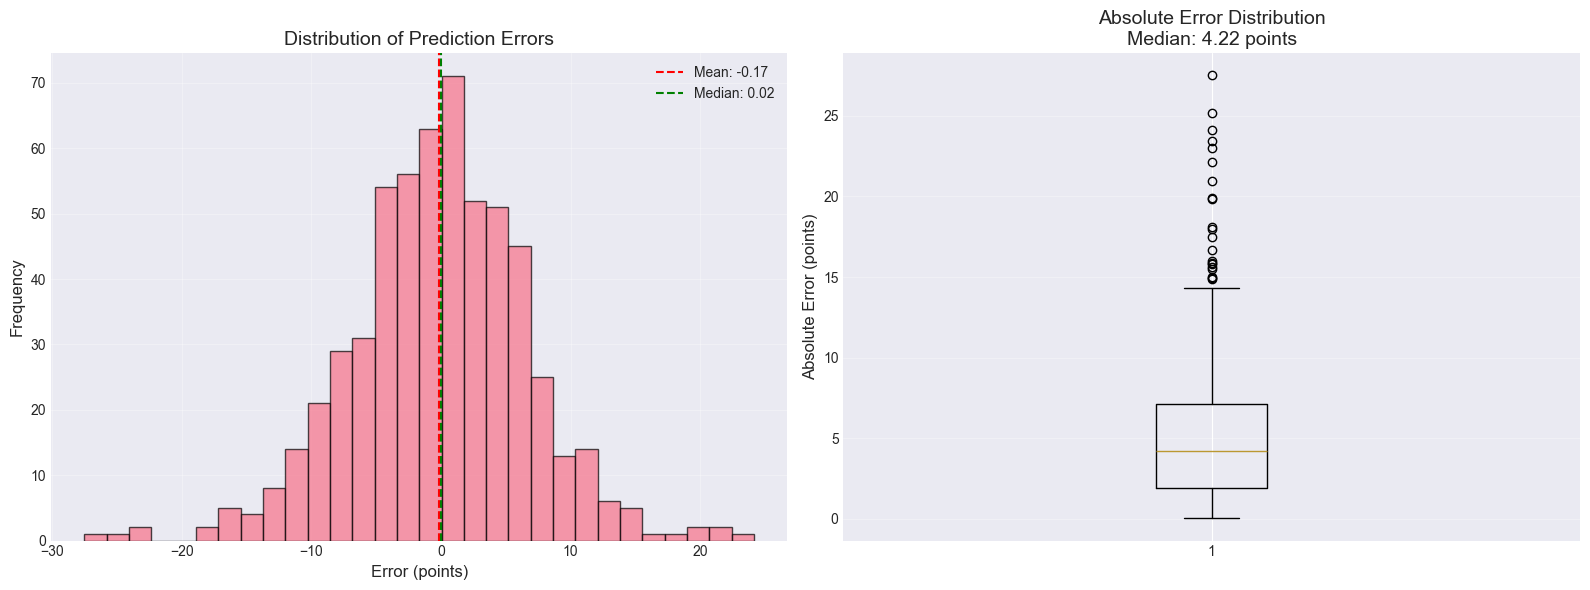


📊 Error Statistics:
   Mean Error: -0.17 points
   Std Error: 6.79 points
   Median Absolute Error: 4.22 points
   95% of errors are within: ±13.28 points


In [8]:
# Distribution des erreurs
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram des erreurs
axes[0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(residuals.mean(), color='red', linestyle='--', 
                label=f'Mean: {residuals.mean():.2f}')
axes[0].axvline(residuals.median(), color='green', linestyle='--', 
                label=f'Median: {residuals.median():.2f}')
axes[0].set_xlabel('Error (points)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Prediction Errors', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot des erreurs absolues
axes[1].boxplot([np.abs(residuals)], vert=True)
axes[1].set_ylabel('Absolute Error (points)', fontsize=12)
axes[1].set_title(f'Absolute Error Distribution\nMedian: {np.median(np.abs(residuals)):.2f} points', 
                 fontsize=14)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n📊 Error Statistics:")
print(f"   Mean Error: {residuals.mean():.2f} points")
print(f"   Std Error: {residuals.std():.2f} points")
print(f"   Median Absolute Error: {np.median(np.abs(residuals)):.2f} points")
print(f"   95% of errors are within: ±{np.percentile(np.abs(residuals), 95):.2f} points")

Cellule 10 : "5️⃣ Analyser les Prédictions par Équipe"

In [9]:
# Prédire le classement final
final_predictions = predictor.predict_final_standings(test_df)

# Classement réel
actual_standings = test_df.groupby('team').agg({
    'target_final_points': 'first'
}).reset_index()
actual_standings.columns = ['team', 'actual_final_points']
actual_standings['actual_rank'] = actual_standings['actual_final_points'].rank(
    ascending=False, method='min'
).astype(int)
actual_standings = actual_standings.sort_values('actual_rank')

# Combiner
comparison = final_predictions.merge(actual_standings, on='team')
comparison['rank_diff'] = comparison['actual_rank'] - comparison['predicted_rank']
comparison['points_diff'] = comparison['actual_final_points'] - comparison['predicted_final_points']

print("\n" + "="*70)
print("FINAL STANDINGS COMPARISON (2022-2023)")
print("="*70)
print(f"\n{'Rank':<6} {'Team':<25} {'Predicted':<12} {'Actual':<12} {'Diff':<8}")
print("-"*70)

for _, row in comparison.iterrows():
    rank_emoji = "✅" if abs(row['rank_diff']) <= 2 else "⚠️"
    print(f"{row['predicted_rank']:<6} {row['team']:<25} "
          f"{row['predicted_final_points']:<12.1f} "
          f"{row['actual_final_points']:<12.1f} "
          f"{row['points_diff']:+8.1f} {rank_emoji}")


FINAL STANDINGS COMPARISON (2022-2023)

Rank   Team                      Predicted    Actual       Diff    
----------------------------------------------------------------------
1      Manchester City           90.1         89.0             -1.1 ✅
2      Arsenal                   82.2         84.0             +1.8 ✅
3      Newcastle United          72.6         71.0             -1.6 ✅
4      Manchester United         70.7         75.0             +4.3 ✅
5      Liverpool                 70.1         67.0             -3.1 ✅
6      Brighton & Hove Albion    65.8         62.0             -3.8 ✅
7      Tottenham Hotspur         59.4         60.0             +0.6 ✅
8      Brentford                 58.1         59.0             +0.9 ✅
9      Aston Villa               57.5         61.0             +3.5 ✅
10     Fulham                    52.2         52.0             -0.2 ✅
11     Chelsea                   46.2         44.0             -2.2 ✅
12     Crystal Palace            45.5         45.0

Cellule 11 : "Visualiser les différences de classement"

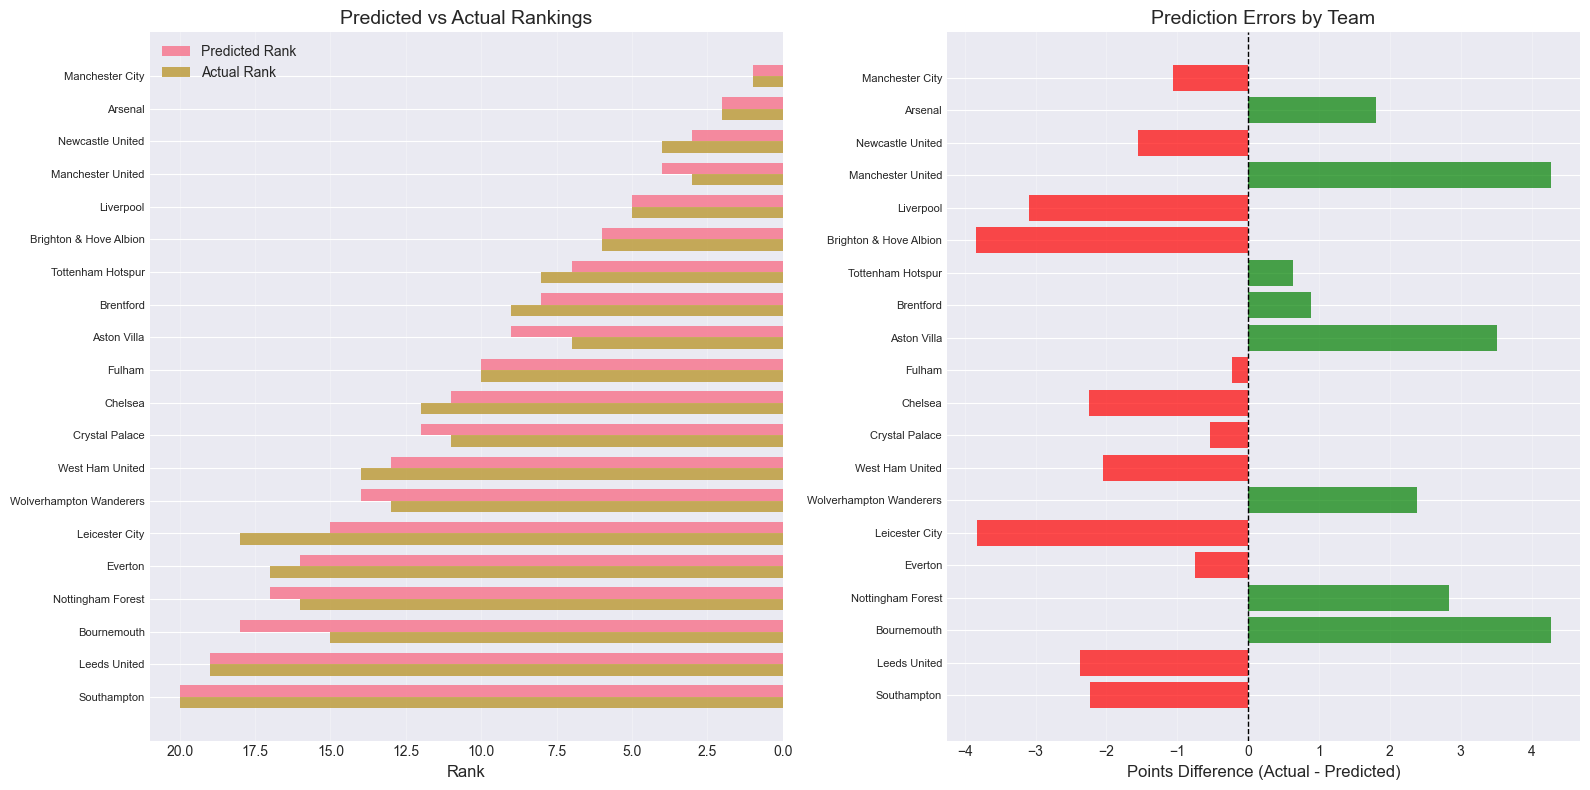

In [10]:
# Visualiser les différences de classement
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Classement prédit vs réel
comparison_sorted = comparison.sort_values('predicted_rank')
x = np.arange(len(comparison_sorted))
width = 0.35

axes[0].barh(x - width/2, comparison_sorted['predicted_rank'], width, 
             label='Predicted Rank', alpha=0.8)
axes[0].barh(x + width/2, comparison_sorted['actual_rank'], width, 
             label='Actual Rank', alpha=0.8)
axes[0].set_yticks(x)
axes[0].set_yticklabels(comparison_sorted['team'], fontsize=8)
axes[0].set_xlabel('Rank', fontsize=12)
axes[0].set_title('Predicted vs Actual Rankings', fontsize=14)
axes[0].legend()
axes[0].invert_yaxis()
axes[0].invert_xaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: Différence de points
colors = ['green' if x >= 0 else 'red' for x in comparison_sorted['points_diff']]
axes[1].barh(x, comparison_sorted['points_diff'], color=colors, alpha=0.7)
axes[1].set_yticks(x)
axes[1].set_yticklabels(comparison_sorted['team'], fontsize=8)
axes[1].set_xlabel('Points Difference (Actual - Predicted)', fontsize=12)
axes[1].set_title('Prediction Errors by Team', fontsize=14)
axes[1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

Cellule 12 : "6️⃣ Meilleurs et Pires Prédictions"

In [12]:
# Top 5 meilleures prédictions
# Vérifier d'abord si la colonne 'abs_error' existe
if 'abs_error' not in comparison.columns:
    # Créer la colonne si elle n'existe pas
    comparison['abs_error'] = np.abs(comparison['points_diff'])

best_predictions = comparison.nsmallest(5, 'abs_error')

print("\n🏆 TOP 5 BEST PREDICTIONS:")
print(f"\n{'Team':<25} {'Predicted':<12} {'Actual':<12} {'Error':<10}")
print("-"*60)
for _, row in best_predictions.iterrows():
    print(f"{row['team']:<25} {row['predicted_final_points']:<12.1f} "
          f"{row['actual_final_points']:<12.1f} {row['abs_error']:<10.1f}")

# Top 5 pires prédictions
worst_predictions = comparison.nlargest(5, 'abs_error')

print("\n⚠️  TOP 5 WORST PREDICTIONS:")
print(f"\n{'Team':<25} {'Predicted':<12} {'Actual':<12} {'Error':<10}")
print("-"*60)
for _, row in worst_predictions.iterrows():
    print(f"{row['team']:<25} {row['predicted_final_points']:<12.1f} "
          f"{row['actual_final_points']:<12.1f} {row['abs_error']:<10.1f}")


🏆 TOP 5 BEST PREDICTIONS:

Team                      Predicted    Actual       Error     
------------------------------------------------------------
Fulham                    52.2         52.0         0.2       
Crystal Palace            45.5         45.0         0.5       
Tottenham Hotspur         59.4         60.0         0.6       
Everton                   36.8         36.0         0.8       
Brentford                 58.1         59.0         0.9       

⚠️  TOP 5 WORST PREDICTIONS:

Team                      Predicted    Actual       Error     
------------------------------------------------------------
Bournemouth               34.7         39.0         4.3       
Manchester United         70.7         75.0         4.3       
Brighton & Hove Albion    65.8         62.0         3.8       
Leicester City            37.8         34.0         3.8       
Aston Villa               57.5         61.0         3.5       


Cellule 13 : "7️⃣ Analyse par Gameweek"

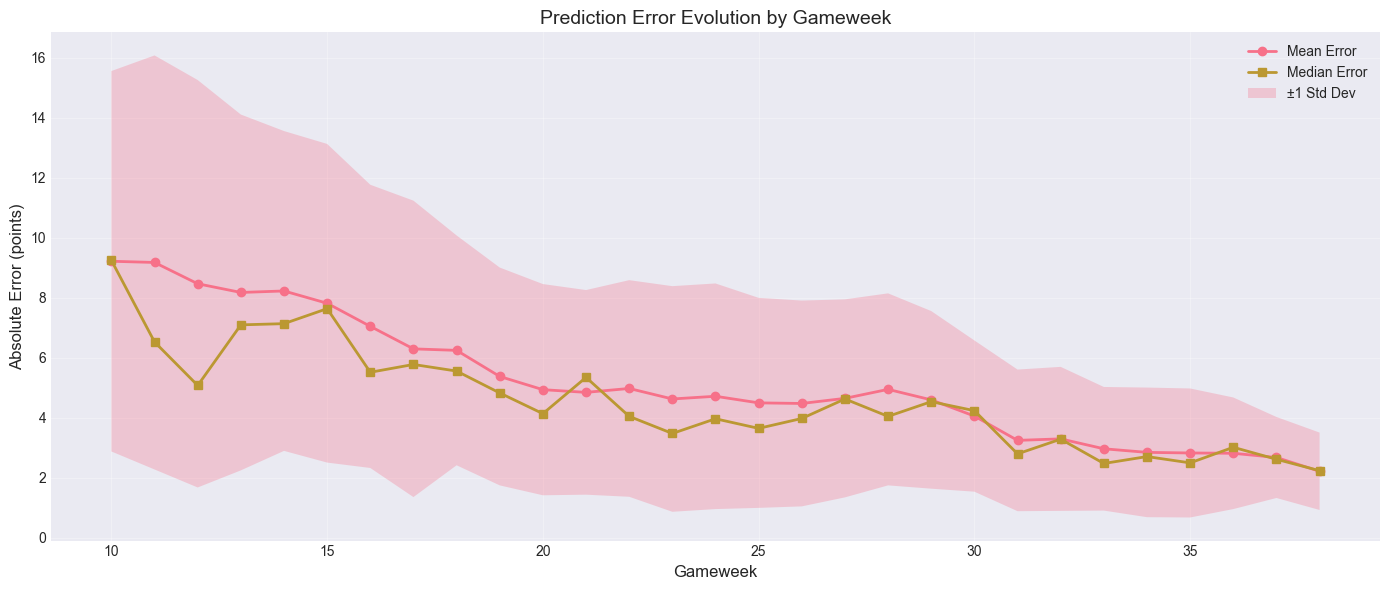


📊 Error Statistics by Gameweek:
 gameweek  Mean Error  Median Error  Std Error
       10        9.22          9.25       6.34
       11        9.18          6.53       6.90
       12        8.47          5.08       6.79
       13        8.18          7.10       5.93
       14        8.23          7.14       5.33
       15        7.82          7.64       5.31
       16        7.05          5.52       4.72
       17        6.30          5.78       4.94
       18        6.25          5.56       3.83
       19        5.38          4.83       3.63
       20        4.94          4.14       3.52
       21        4.85          5.35       3.41
       22        4.98          4.05       3.61
       23        4.63          3.48       3.76
       24        4.72          3.97       3.76
       25        4.50          3.65       3.50
       26        4.48          3.98       3.43
       27        4.65          4.63       3.30
       28        4.95          4.05       3.20
       29        4.60      

In [13]:
# Performance par gameweek
results_by_gw = results_df.groupby('gameweek').agg({
    'abs_error': ['mean', 'median', 'std']
}).round(2)

results_by_gw.columns = ['Mean Error', 'Median Error', 'Std Error']
results_by_gw = results_by_gw.reset_index()

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(results_by_gw['gameweek'], results_by_gw['Mean Error'], 
        marker='o', label='Mean Error', linewidth=2)
ax.plot(results_by_gw['gameweek'], results_by_gw['Median Error'], 
        marker='s', label='Median Error', linewidth=2)
ax.fill_between(results_by_gw['gameweek'], 
                results_by_gw['Mean Error'] - results_by_gw['Std Error'],
                results_by_gw['Mean Error'] + results_by_gw['Std Error'],
                alpha=0.3, label='±1 Std Dev')

ax.set_xlabel('Gameweek', fontsize=12)
ax.set_ylabel('Absolute Error (points)', fontsize=12)
ax.set_title('Prediction Error Evolution by Gameweek', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Error Statistics by Gameweek:")
print(results_by_gw.to_string(index=False))

Cellule 14 : "8️⃣ Résumé et Conclusions"

In [14]:
# Calculer des métriques supplémentaires
top4_pred = set(comparison.nsmallest(4, 'predicted_rank')['team'])
top4_actual = set(comparison.nsmallest(4, 'actual_rank')['team'])
top4_accuracy = len(top4_pred & top4_actual) / 4 * 100

bottom3_pred = set(comparison.nlargest(3, 'predicted_rank')['team'])
bottom3_actual = set(comparison.nlargest(3, 'actual_rank')['team'])
bottom3_accuracy = len(bottom3_pred & bottom3_actual) / 3 * 100

print("\n" + "="*70)
print("FINAL EVALUATION SUMMARY")
print("="*70)

print(f"\n📊 Overall Performance:")
print(f"   Test MAE: {mae:.2f} points")
print(f"   Test RMSE: {rmse:.2f} points")
print(f"   Test R²: {r2:.4f}")
print(f"   Median Absolute Error: {np.median(np.abs(residuals)):.2f} points")

print(f"\n🎯 Ranking Accuracy:")
print(f"   Top 4 Accuracy: {top4_accuracy:.1f}% ({len(top4_pred & top4_actual)}/4 teams)")
print(f"   Bottom 3 Accuracy: {bottom3_accuracy:.1f}% ({len(bottom3_pred & bottom3_actual)}/3 teams)")
print(f"   Teams with rank error ≤2: {(comparison['rank_diff'].abs() <= 2).sum()}/{len(comparison)}")

print(f"\n✨ Key Insights:")
print(f"   - Model explains {r2*100:.1f}% of variance in final points")
print(f"   - Average prediction error: {mae:.2f} points (out of ~38-100 range)")
print(f"   - 95% of predictions within ±{np.percentile(np.abs(residuals), 95):.1f} points")
print(f"   - Best predictions: {best_predictions.iloc[0]['team']} (error: {best_predictions.iloc[0]['abs_error']:.2f})")
print(f"   - Worst predictions: {worst_predictions.iloc[0]['team']} (error: {worst_predictions.iloc[0]['abs_error']:.2f})")

print(f"\n💡 Recommendations:")
if mae < 5:
    print(f"   ✅ Excellent performance! Model is production-ready.")
elif mae < 7:
    print(f"   ✅ Good performance. Consider minor improvements.")
else:
    print(f"   ⚠️  Performance could be improved. Consider:")
    print(f"      - Adding more features")
    print(f"      - Feature engineering")
    print(f"      - Collecting more training data")

print("\n" + "="*70)


FINAL EVALUATION SUMMARY

📊 Overall Performance:
   Test MAE: 5.19 points
   Test RMSE: 6.79 points
   Test R²: 0.8534
   Median Absolute Error: 4.22 points

🎯 Ranking Accuracy:
   Top 4 Accuracy: 100.0% (4/4 teams)
   Bottom 3 Accuracy: 66.7% (2/3 teams)
   Teams with rank error ≤2: 18/20

✨ Key Insights:
   - Model explains 85.3% of variance in final points
   - Average prediction error: 5.19 points (out of ~38-100 range)
   - 95% of predictions within ±13.3 points
   - Best predictions: Fulham (error: 0.22)
   - Worst predictions: Bournemouth (error: 4.28)

💡 Recommendations:
   ✅ Good performance. Consider minor improvements.



Cellule 15 : "9️⃣ Sauvegarder les Résultats"

In [15]:
# Sauvegarder les prédictions
output_dir = Path('../predictions')
output_dir.mkdir(exist_ok=True)

timestamp = predictor.metadata['timestamp']
output_file = output_dir / f'test_predictions_{timestamp}.csv'

comparison.to_csv(output_file, index=False)
print(f"✅ Predictions saved to {output_file}")

# Sauvegarder un résumé
summary = {
    'model_name': predictor.metadata['model_name'],
    'timestamp': timestamp,
    'test_mae': float(mae),
    'test_rmse': float(rmse),
    'test_r2': float(r2),
    'median_abs_error': float(np.median(np.abs(residuals))),
    'top4_accuracy': float(top4_accuracy),
    'bottom3_accuracy': float(bottom3_accuracy)
}

import json
summary_file = output_dir / f'evaluation_summary_{timestamp}.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✅ Summary saved to {summary_file}")
print("\n🎉 Evaluation complete!")

✅ Predictions saved to ..\predictions\test_predictions_20251212_215937.csv
✅ Summary saved to ..\predictions\evaluation_summary_20251212_215937.json

🎉 Evaluation complete!
